In [1]:
import numpy as np
import math # trigonometry, pi
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import re # function string parsing

### Fibonacci

In [3]:
def fibonacci(n_numbers=10, end_number=None):
    """Fibonacci series
    iterative sum of last two implementation

    Parameters
    ----------
    n_numbers: number of numbers in fibonacci series
    end_number: upper bound of series"""
    fib_series = [1]
    first = 0
    second = 1
    for _ in range(n_numbers - 1):
        # second is sum of two
        # first is second
        second = first + second
        first = second - first

        if not end_number is None:
            if second > end_number:
                return fib_series

        fib_series.append(second)

    return fib_series

In [4]:
def fibonacci_golden(n_numbers=10, end_number=None):
    """Fibonacci series
    Golden Ratio implementation
    golden ratio = 1.618...
    next element = last element * golden ratio
    
    !!!
    There is an upper bound when elements reach infinity
        -> 1476 is a possible limit
    Raises an error when this limit exceeded

    Parameters
    ----------
    n_numbers: number of numbers in fibonacci series
    end_number: upper bound of series"""
    if n_numbers == 1:
        return [1]
    golden_ratio = 1.618
    inf = float("inf")
    fib_series = [1, 1]
    for _ in range(n_numbers - 2):
        next_raw = fib_series[-1] * golden_ratio
        if next_raw == inf:
            raise BaseException("Number limit exceeded")
        next = round(next_raw)
        if not end_number is None:
            if next > end_number:
                return fib_series

        fib_series.append(next)

    return fib_series

In [98]:
%%time
fib = fibonacci(1476)

Wall time: 0 ns


In [99]:
%%time
fib = fibonacci_golden(1476)

Wall time: 0 ns


## Mathematical Expressions and derivative
### (Simple to understand, non optimised)

In [7]:
class Expr:
    pass

In [8]:
class Const(Expr):
    """Constant
    example: 5"""
    def __init__(self, val):
        self.val = val
    
    def __str__(self):
        return str(self.val)
    
    def eval(self, env=None):
        return self.val
    
    def der(self, respect_to=None):
        return Const(0)

In [9]:
class Var(Expr):
    """Variable
    example: x"""
    def __init__(self, name):
        self.name = name
    
    def __str__(self):
        return self.name
    
    def eval(self, env):
        return env[self.name]
    
    def der(self, respect_to=None):
        if not respect_to is None and respect_to != self.name:
            return Const(0)
        else:
            return Const(1)

In [10]:
class Add(Expr):
    """Addition"""
    def __init__(self, left, right):
        self.left = left
        self.right = right
            
    def __str__(self):
        return "(" + str(self.left) + " + " + str(self.right) + ")"
    
    def eval(self, env):
        return self.left.eval(env) + self.right.eval(env)
    
    def der(self, respect_to=None):
        return Add(self.left.der(respect_to), self.right.der(respect_to))

In [11]:
class Sub(Expr):
    """Substraction"""
    def __init__(self, left, right):
        self.left = left
        self.right = right
    
    def __str__(self):
        return "(" + str(self.left) + " - " + str(self.right) + ")"
    
    def eval(self, env):
        return self.left.eval(env) - self.right.eval(env)
    
    def der(self, respect_to=None):
        return Sub(self.left.der(respect_to), self.right.der(respect_to))

In [12]:
class Mul(Expr):
    """Multiplication"""
    def __init__(self, left, right):
        self.left = left
        self.right = right
        
    def __str__(self):
        return "(" + str(self.left) + " * " + str(self.right) + ")"
    
    def eval(self, env):
        return self.left.eval(env) * self.right.eval(env)
    
    def der(self, respect_to=None):
        return Add(Mul(self.left.der(respect_to), self.right),
                    Mul(self.left, self.right.der(respect_to)))

In [13]:
class Div(Expr):
    """Division"""
    def __init__(self, left, right):
        self.left = left
        self.right = right
        
    def __str__(self):
        return "(" + str(self.left) + " / " + str(self.right) + ")"
    
    def eval(self, env):
        return self.left.eval(env) / self.right.eval(env)
    
    def der(self, respect_to=None):
        return Div(Sub(Mul(self.left.der(respect_to), self.right),
                        Mul(self.left, self.right.der(respect_to))),
                      Mul(self.right, self.right))

In [14]:
class Quad(Expr):
    """Quadratic equations
    ex: x^2"""
    def __init__(self, var, power):
        self.var = var
        self.power = power
    
    def __str__(self):
        return str(self.var) + "^" + str(self.power)
    
    def eval(self, env):
        return self.var.eval(env) ** self.power.eval(env)
    
    def der(self, respect_to=None):
        return Mul(Mul(Const(self.power.eval()), self.var.der(respect_to)),
                    Quad(self.var, Const(self.power.eval() - 1)))

In [15]:
class Exp(Expr):
    """Exponential
    example: e^x"""
    def __init__(self, base, power):
        self.base = base
        self.power = power
        
    def __str__(self):
        if isinstance(self.base, Const) and self.base.eval() == math.e:
            return "e" + "^" + str(self.power)
        return str(self.base) + "^" + str(self.power)
    
    def eval(self, env):
        return math.pow(self.base.eval(env), self.power.eval(env))
    
    def der(self, respect_to=None):
        return Mul(Mul(self, Log(self.base)), self.power.der(respect_to))

In [16]:
class Log(Expr):
    """Logarithms
    example: ln(x), log10(x)"""
    def __init__(self, x, base=Const(math.e)):
        self.x = x
        self.base = base
    
    def __str__(self):
        if isinstance(self.base, Const) and self.base.eval() == math.e:
            return "ln(" + str(self.x) + ")"
        return "log" + str(self.base) + "(" + str(self.x) + ")"
    
    def eval(self, env):
        return math.log(self.x.eval(env), self.base.eval(env)) 
    
    def der(self, respect_to=None):
        return Div(self.x.der(respect_to),
                   Mul(self.x, Log(self.base)))

In [17]:
class Sin(Expr):
    """Sinus"""
    def __init__(self, x):
        self.x = x
        
    def __str__(self):
        return "sin(" + str(self.x) + ")"
    
    def eval(self, env):
        return math.sin(self.x.eval(env))
    
    def der(self, respect_to=None):
        return Mul(Cos(self.x), self.x.der(respect_to))

In [214]:
class Cos(Expr):
    """Cosinus"""
    def __init__(self, x):
        self.x = x
        
    def __str__(self):
        return "cos(" + str(self.x) + ")"
    
    def eval(self, env):
        return math.cos(self.x.eval(env))
    
    def der(self, respect_to=None):
        return Mul(Const(-1), Mul(Sin(self.x), self.x.der(respect_to)))

In [71]:
class Tan(Expr):
    """Tangent"""
    def __init__(self, x):
        self.x = x
        
    def __str__(self):
        return "tan(" + str(self.x) + ")"
    
    def eval(self, env):
        return math.tan(self.x.eval(env))
    
    def der(self, respect_to=None):
        return Div(self.x.der(respect_to),
                  Quad(Cos(self.x), Const(2)))

In [72]:
class Cot(Expr):
    """Cotangent"""
    def __init__(self, x):
        self.x = x
        
    def __str__(self):
        return "cot(" + str(self.x) + ")"
    
    def eval(self, env):
        return 1 / math.tan(self.x.eval(env))
    
    def der(self, respect_to=None):
        return Div(Mul(Const(-1), self.x.der(respect_to)),
                  Quad(Sin(self.x), Const(2)))

### Helper Functions

In [70]:
def factorial(n):
    f = 1
    for i in range(1, n+1):
        f *= i
    return f

In [149]:
def taylor_expr(expr, a=0, order=5):
    """Find taylor series of a given expression
    
    Parameters
    ----------
    expr: expression of function (class Expr)
    a: point which taylor series will be found
    order: order of taylor series
        (increase order to increase precision)
    
    Return
    ------
    expr: taylor series (class Expr)"""
    # g(x) = from n=0 to order: sum(f'nth(a) * ((x - a) ** n) / n!)
    env = {"x": a}
    # zeroth order
    taylor_func = Const(expr.eval(env))
    deriv = expr.der()
    # for higher orders than zeroth
    for n in range(1, order + 1):
        temp_expr = Div(Mul(Const(deriv.eval(env)), 
                            Quad(Sub(Var("x"), Const(a)), Const(n))), 
                        Const(factorial(n)))
        taylor_func = Add(taylor_func, temp_expr)
        deriv = deriv.der()
        
    return taylor_func

In [21]:
def jacobian(expr, variables):
    """Calculate jacobian vector of an expression
    respect to variables
    
    Parameters
    ----------
    expr: expression (function)
        that belongs to Expr class
    variables: list of variables to take derivatives
        ie. ["x", "y", "z"]"""
    j = [0] * len(variables)
    for i, v in enumerate(variables):
        j[i] = expr.der(v)
    
    return j

#### plotting

In [83]:
def plot_expr(expr, interval, return_results=False):
    var = "x"
    interval = list(interval)
    #vals = list(map(lambda x: expr.eval({var: x}), interval))
    vals = [0 for _ in interval]
    i = 0
    while i < len(interval):
        # if function is undefined at that point,
        # dont take it to result
        try:
            val = expr.eval({var: interval[i]})
            vals[i] = val
            i += 1
        except:
            del vals[i]
            del interval[i]
        
    # plotting
    plt.figure()
    xmin, xmax = interval[0], interval[-1]
    ymin, ymax = min(vals), max(vals)
    #plt.xlim((xmin, xmax))
    #plt.ylim((ymin, ymax))
    plt.hlines(y=0, xmin=xmin, xmax=xmax)
    plt.vlines(x=0, ymin=ymin, ymax=ymax)
    plt.xlabel(var)
    plt.ylabel("y")
    plt.title("f(" + var + ")" + " = " + str(expr))
    plt.plot(interval, vals)
    
    if return_results:
        return interval, vals

### Mathematical Expressions and derivative with simplification functions
### Optimised
### (A bit Complicated but faster)
### NOT FINISHED

In [228]:
class Expr:
    pass

In [229]:
class Const(Expr):
    def __init__(self, val):
        self.val = val
    
    def __str__(self):
        return str(self.val)
    
    def eval(self, env=None):
        return self.val
    
    def der(self, respect_to=None):
        return Const(0)

In [230]:
class Var(Expr):
    def __init__(self, name):
        self.name = name
    
    def __str__(self):
        return self.name
    
    def eval(self, env):
        return env[self.name]
    
    def der(self, respect_to=None):
        if not respect_to is None and respect_to != self.name:
            return Const(0)
        else:
            return Const(1)

In [256]:
class Add(Expr):
    def __init__(self, left, right):
        self.left = left
        self.right = right
        self.expr = self
        if isinstance(right, Const) and not right.eval():
            self.expr = self.left
        elif isinstance(left, Const) and not left.eval():
            self.expr = self.right
            
    def __str__(self):
        if not isinstance(self.expr, self.__class__):
            return str(self.expr)
        return "(" + str(self.left) + " + " + str(self.right) + ")"
    
    def eval(self, env):
        if not isinstance(self.expr, self.__class__):
            return self.expr.eval(env)
        return self.left.eval(env) + self.right.eval(env)
    
    def der(self, respect_to=None):
        if not isinstance(self.expr, self.__class__):
            return self.expr.der(respect_to)
        return Add(self.left.der(respect_to), self.right.der(respect_to))

In [232]:
class Sub(Expr):
    def __init__(self, left, right):
        self.left = left
        self.right = right
        self.expr = self
        if isinstance(right, Const) and not right.eval():
            self.expr = self.left
    
    def __str__(self):
        if not isinstance(self.expr, self.__class__):
            return str(self.expr)
        return "(" + str(self.left) + " - " + str(self.right) + ")"
    
    def eval(self, env):
        if not isinstance(self.expr, self.__class__):
            return self.expr.eval(env)
        return self.left.eval(env) - self.right.eval(env)
    
    def der(self, respect_to=None):
        if not isinstance(self.expr, self.__class__):
            return self.expr.der(respect_to)
        return Sub(self.left.der(respect_to), self.right.der(respect_to))

In [233]:
class Mul(Expr):
    def __init__(self, left, right):
        self.left = left
        self.right = right
        self.expr = self
        if isinstance(right, Const) and right.eval() == 1:
            self.expr = left
        elif isinstance(left, Const) and left.eval() == 1:
            self.expr = right
        # multiplying by 0 is 0
        elif isinstance(right, Const) and not right.eval():
            self.expr = right
        elif isinstance(left, Const) and not left.eval():
            self.expr = left
        
    def __str__(self):
        if not isinstance(self.expr, self.__class__):
            return str(self.expr)
        return "(" + str(self.left) + " * " + str(self.right) + ")"
    
    def eval(self, env):
        if not isinstance(self.expr, self.__class__):
            return self.expr.eval(env)
        return self.left.eval(env) * self.right.eval(env)
    
    def der(self, respect_to=None):
        if not isinstance(self.expr, self.__class__):
            return self.expr.der(respect_to)
        return Add(Mul(self.left.der(respect_to), self.right),
                    Mul(self.left, self.right.der(respect_to)))

In [234]:
class Div(Expr):
    def __init__(self, left, right):
        self.left = left
        self.right = right
        self.expr = self
        if isinstance(right, Const) and right.eval() == 1:
            self.expr = self.left
        elif isinstance(left, Const) and not left.eval():
            self.expr = self.left
        
    def __str__(self):
        if not isinstance(self.expr, self.__class__):
            return str(self.expr)
        return "(" + str(self.left) + " / " + str(self.right) + ")"
    
    def eval(self, env):
        if not isinstance(self.expr, self.__class__):
            return self.expr.eval(env)
        return self.left.eval(env) / self.right.eval(env)
    
    def der(self, respect_to=None):
        if not isinstance(self.expr, self.__class__):
            return self.expr.der(respect_to)
        return Div(Sub(Mul(self.left.der(respect_to), self.right),
                        Mul(self.left, self.right.der(respect_to))),
                      Mul(self.right, self.right))

In [235]:
class Quad(Expr):
    def __init__(self, var, power):
        self.var = var
        self.power = power
        self.expr = self
        if isinstance(power, Const) and not power.eval():
            self.expr = Const(1)
        elif isinstance(power, Const) and power.eval() == 1:
            self.expr = self.var
    
    def __str__(self):
        if not isinstance(self.expr, self.__class__):
            return str(self.expr)
        return "(" + str(self.var) + "^" + str(self.power) + ")"
    
    def eval(self, env):
        if not isinstance(self.expr, self.__class__):
            return self.expr.eval(env)
        return self.var.eval(env) ** self.power.eval(env)
    
    def der(self, respect_to=None):
        if not isinstance(self.expr, self.__class__):
            return self.expr.der(respect_to)
        return Mul(Mul(Const(self.power.eval()), self.var.der(respect_to)),
                    Quad(self.var, Const(self.power.eval() - 1)))

In [236]:
class Exp(Expr):
    """Exponential
    example: e^x"""
    def __init__(self, base, power):
        self.base = base
        self.power = power
        
    def __str__(self):
        if isinstance(self.base, Const) and self.base.eval() == math.e:
            return "e" + "^" + str(self.power)
        return str(self.base) + "^" + str(self.power)
    
    def eval(self, env):
        return math.pow(self.base.eval(env), self.power.eval(env))
    
    def der(self, respect_to=None):
        return Mul(Mul(self, Log(self.base)), self.power.der(respect_to))

In [237]:
class Log(Expr):
    """Logarithms
    example: ln(x), log10(x)"""
    def __init__(self, x, base=Const(math.e)):
        self.x = x
        self.base = base
    
    def __str__(self):
        if isinstance(self.base, Const) and self.base.eval() == math.e:
            return "ln(" + str(self.x) + ")"
        return "log" + str(self.base) + "(" + str(self.x) + ")"
    
    def eval(self, env):
        return math.log(self.x.eval(env), self.base.eval(env)) 
    
    def der(self, respect_to=None):
        return Div(self.x.der(respect_to),
                   Mul(self.x, Log(self.base)))

In [238]:
class Sin(Expr):
    """Sinus"""
    def __init__(self, x):
        self.x = x
        
    def __str__(self):
        return "sin(" + str(self.x) + ")"
    
    def eval(self, env):
        return math.sin(self.x.eval(env))
    
    def der(self, respect_to=None):
        return Mul(Cos(self.x), self.x.der(respect_to))

In [239]:
class Cos(Expr):
    """Cosinus"""
    def __init__(self, x):
        self.x = x
        
    def __str__(self):
        return "cos(" + str(self.x) + ")"
    
    def eval(self, env):
        return math.cos(self.x.eval(env))
    
    def der(self, respect_to=None):
        return Mul(Const(-1), Mul(Sin(self.x), self.x.der(respect_to)))

In [240]:
class Tan(Expr):
    """Tangent"""
    def __init__(self, x):
        self.x = x
        
    def __str__(self):
        return "tan(" + str(self.x) + ")"
    
    def eval(self, env):
        return math.tan(self.x.eval(env))
    
    def der(self, respect_to=None):
        return Div(self.x.der(respect_to),
                  Quad(Cos(self.x), Const(2)))

In [241]:
class Cot(Expr):
    """Cotangent"""
    def __init__(self, x):
        self.x = x
        
    def __str__(self):
        return "cot(" + str(self.x) + ")"
    
    def eval(self, env):
        return 1 / math.tan(self.x.eval(env))
    
    def der(self, respect_to=None):
        return Div(Mul(Const(-1), self.x.der(respect_to)),
                  Quad(Sin(self.x), Const(2)))

### Test

In [23]:
print(Const(5))

5


In [24]:
# expr: x*x + 3x + 5
expr = Add(Add(Mul(Var("x"), Var("x")), Mul(Const(3), Var("x"))), Const(5))
# for eval
env = {"x": 5}

# derivative of expr respect to x: 2x + 3
der = expr.der("x")

In [25]:
print(expr)

(((x * x) + (3 * x)) + 5)


In [26]:
expr.eval(env)

45

In [27]:
print(der)

((((1 * x) + (x * 1)) + ((0 * x) + (3 * 1))) + 0)


In [28]:
der.eval(env)

13

#### x / (1-x)

In [29]:
expr = Div(Var("x"), Sub(Const(1), Var("x")))
der = expr.der("x")

In [30]:
print(expr)
print(der)

(x / (1 - x))
(((1 * (1 - x)) - (x * (0 - 1))) / ((1 - x) * (1 - x)))


In [31]:
print(expr.eval({"x": 1/2}))
print(der.eval({"x": 1/2}))

1.0
4.0


c:\users\yigit\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


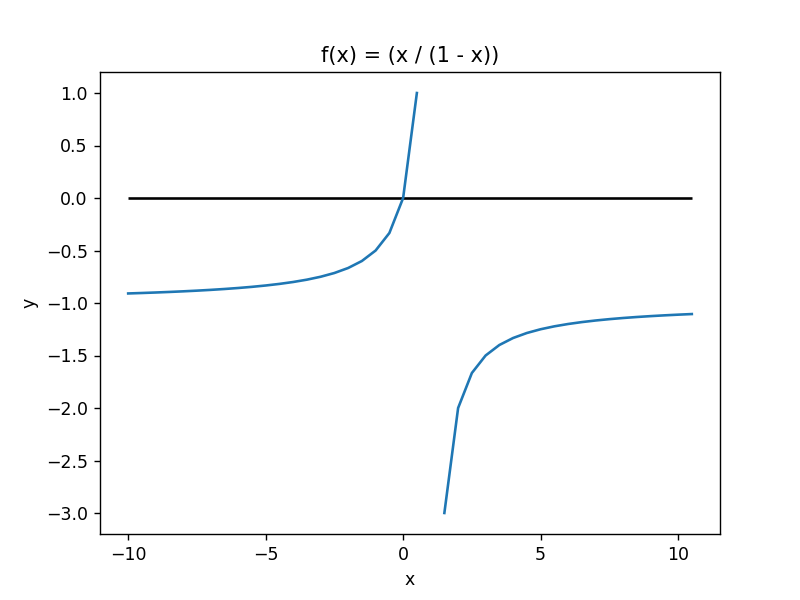

In [32]:
plot_expr(expr, np.arange(-10, 11, 0.5))

#### x^3

In [33]:
expr = Mul(Mul(Var("x"), Var("x")), Var("x"))

<IPython.core.display.Javascript object>


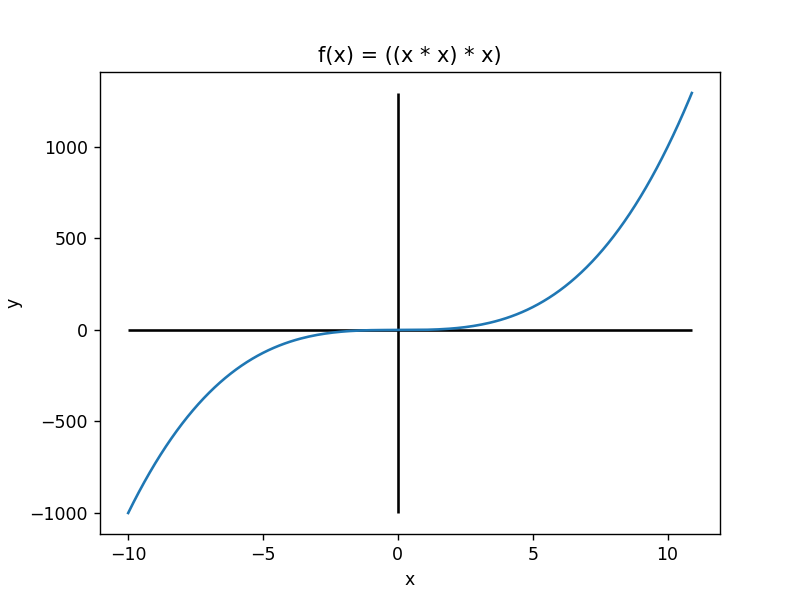

In [34]:
plot_expr(expr, np.arange(-10, 11, 0.1))

In [527]:
expr = Quad(Var("x"), Const(3))
der = expr.der("x")

In [528]:
print(expr)
print(der)

(x^3)
(3 * (x^2))


In [529]:
print(expr.eval({"x": 4}))
print(der.eval({"x": 4}))

64
48


<IPython.core.display.Javascript object>


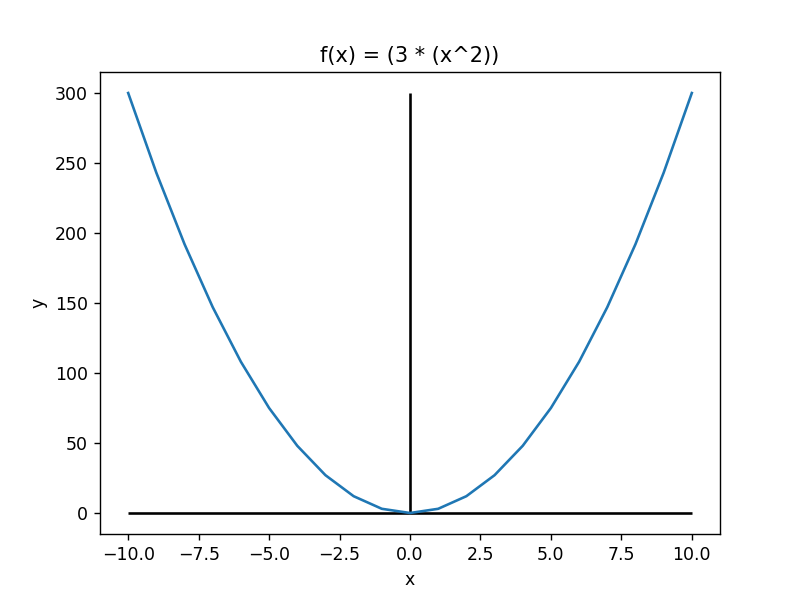

In [530]:
plot_expr(der, np.arange(-10, 11, 1))

#### 1 / x

In [479]:
expr = Div(Const(1), Var("x"))
der = expr.der("x")

In [480]:
print(der)

(((0 * x) - (1 * 1)) / (x * x))


#### x^2 + 2x + 1

In [103]:
expr = Add(Quad(Var("x"), Const(2)), Add(Mul(Const(2), Var("x")), Const(1)))
der = expr.der("x")

In [104]:
print(expr)

(x^2 + ((2 * x) + 1))


<IPython.core.display.Javascript object>


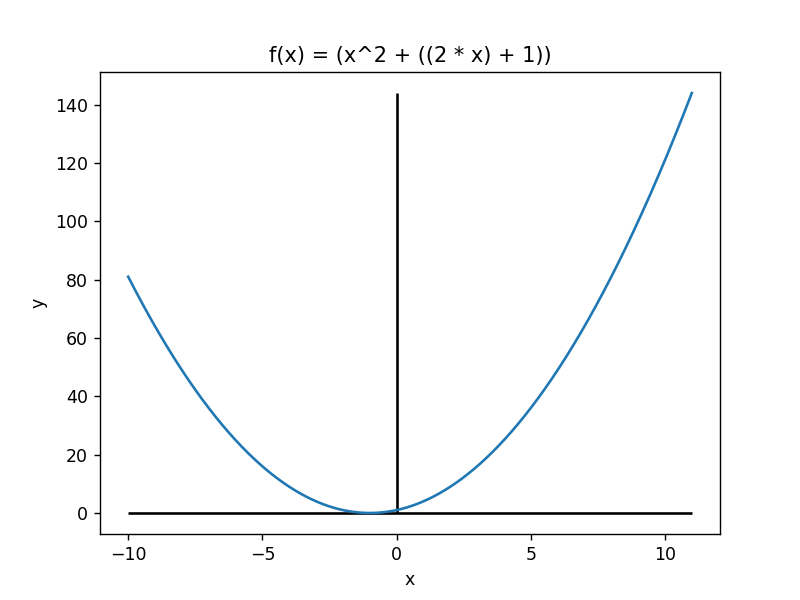

In [105]:
plot_expr(expr, np.arange(-10, 11, 0.001))

#### 1 / (1 + x^2)

In [516]:
expr = Div(Const(1), Add(Const(1), Quad(Var("x"), Const(2))))
der = expr.der("x")

In [517]:
print(der)

(((0 * (1 + (x^2))) - (1 * (2 * (x^1)))) / ((1 + (x^2)) * (1 + (x^2))))


<IPython.core.display.Javascript object>


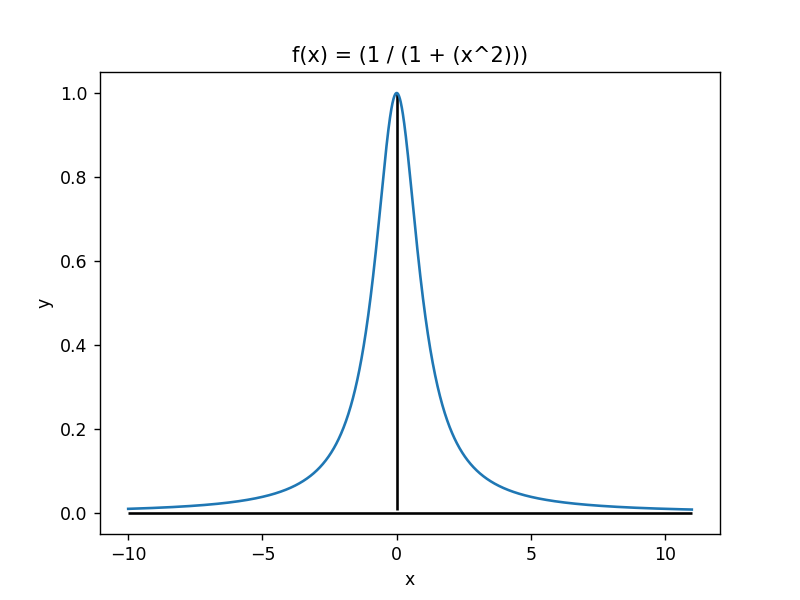

In [518]:
plot_expr(expr, np.arange(-10, 11, 0.01))

#### x^x

In [592]:
expr = Exp(Var("x"), Var("x"))

In [593]:
print(expr)

(x^x)


In [594]:
expr.eval({"x": 3})

27.0

<IPython.core.display.Javascript object>


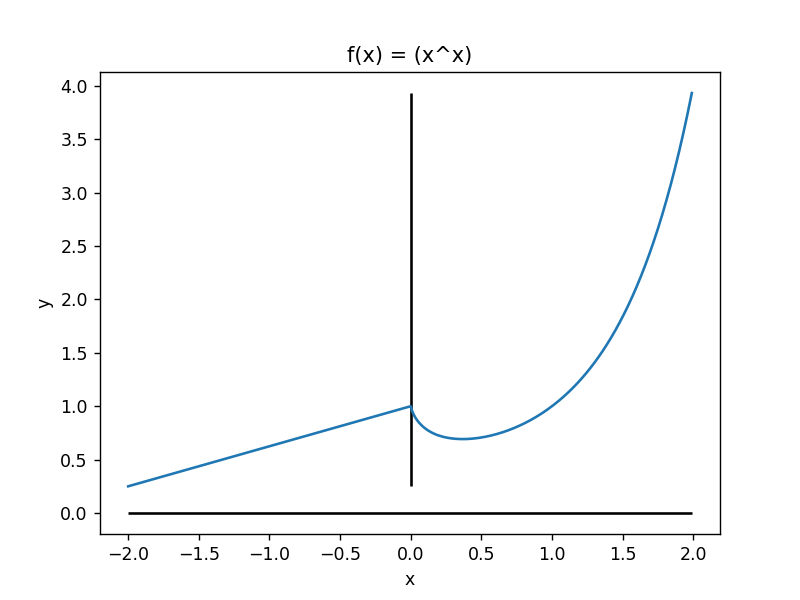

In [616]:
plot_expr(expr, np.arange(-2, 2, 0.01))

#### e^x

In [128]:
expr = Exp(Const(math.e), Var("x"))
der = expr.der("x")

In [129]:
print(expr)
print(der)

e^x
((e^x * ln(2.718281828459045)) * 1)


<IPython.core.display.Javascript object>


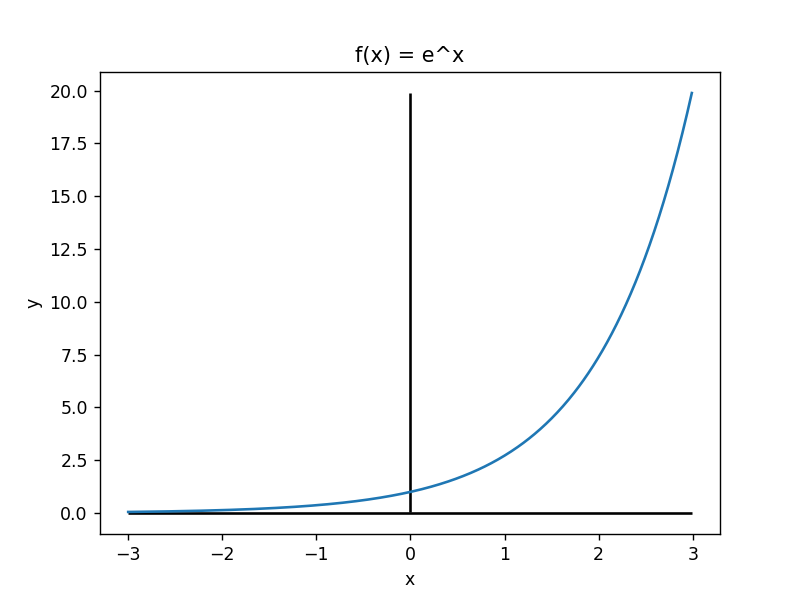

In [130]:
plot_expr(expr, np.arange(-3, 3, 0.01))

#### ln(x)

In [89]:
expr = Log(Var("x"), base=Const(math.e))
der = expr.der("x")

In [90]:
print(expr)
print(der)

ln(x)
(1 / (x * ln(2.718281828459045)))


<IPython.core.display.Javascript object>


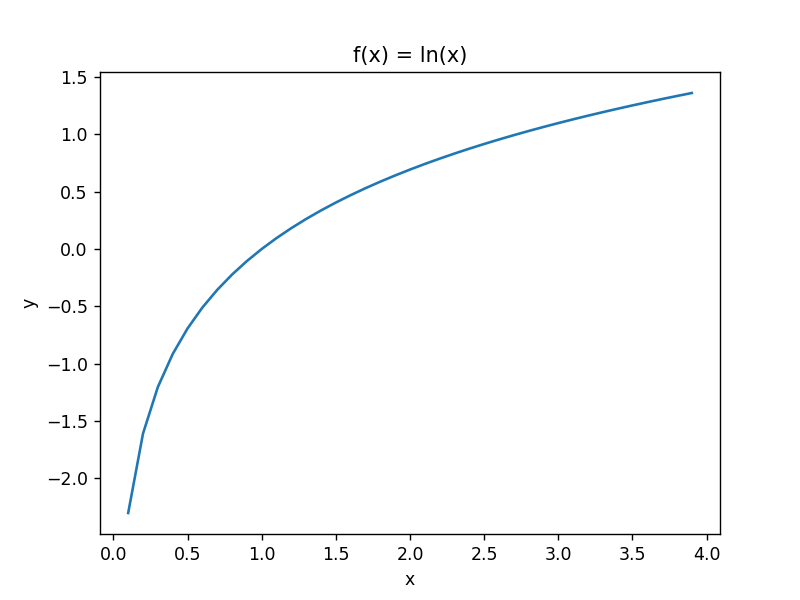

In [91]:
plot_expr(expr, np.arange(0, 4, 0.1))

c:\users\yigit\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


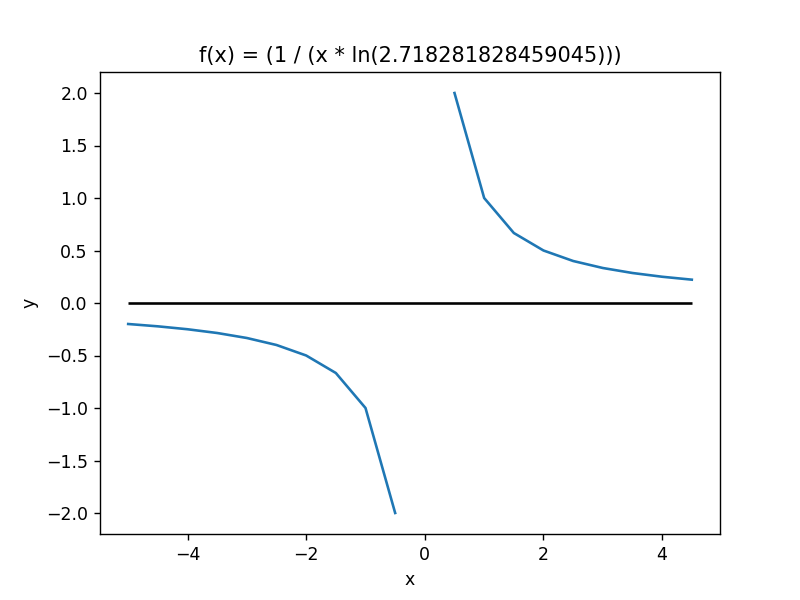

In [747]:
plot_expr(der, np.arange(-5, 5, 0.5))

#### sin(e^x)

In [131]:
expr = Sin(Exp(Const(math.e), Var("x")))

In [132]:
print(expr)

sin(e^x)


<IPython.core.display.Javascript object>


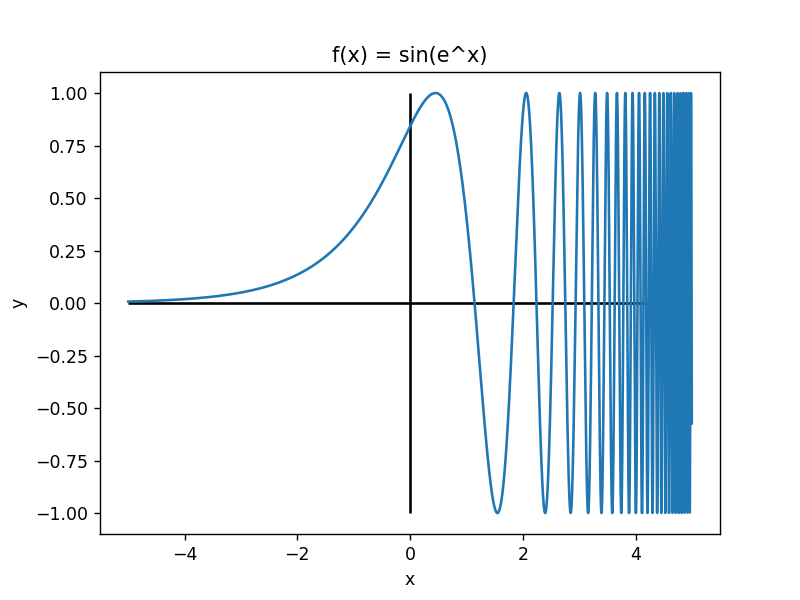

In [133]:
plot_expr(expr, np.arange(-5, 5, 0.001))

#### sin(x^2)

In [117]:
expr = Sin(Quad(Var("x"), Const(2)))
der = expr.der("x")

In [118]:
print(expr)
print(der)

sin(x^2)
(cos(x^2) * ((2 * 1) * x^1))


<IPython.core.display.Javascript object>


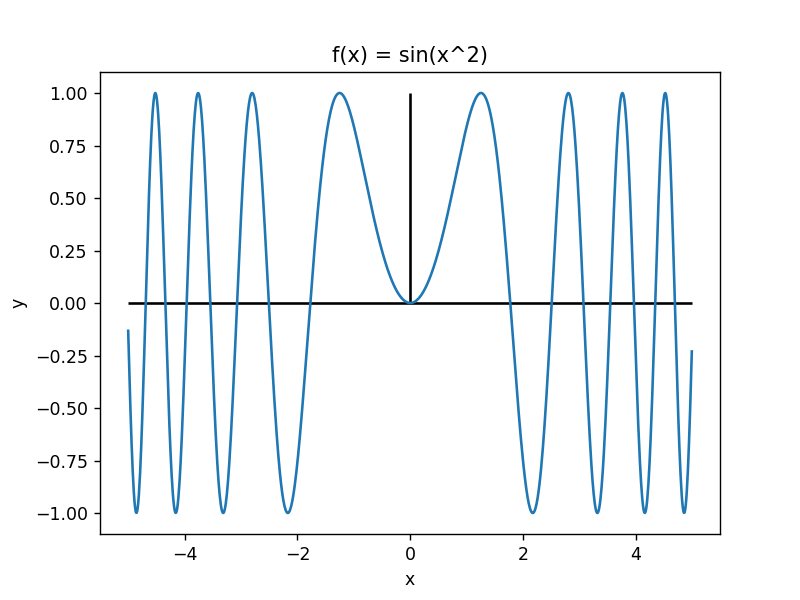

In [119]:
plot_expr(expr, np.arange(-5, 5, 0.01))

<IPython.core.display.Javascript object>


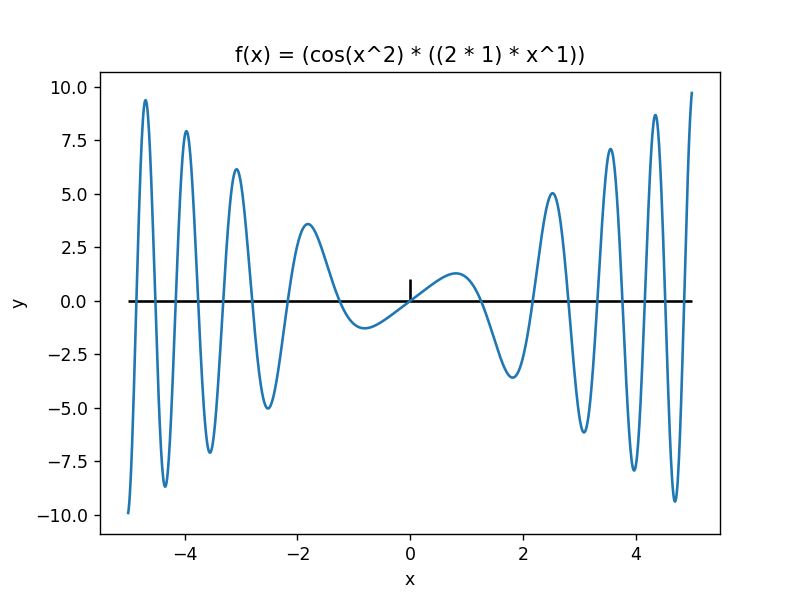

In [120]:
plot_expr(der, np.arange(-5, 5, 0.01))

#### sqr(x)

In [148]:
expr = Quad(Var("x"), Const(1/2))
der = expr.der("x")

In [149]:
print(expr)
print(der)

x^0.5
((0.5 * 1) * x^-0.5)


<IPython.core.display.Javascript object>


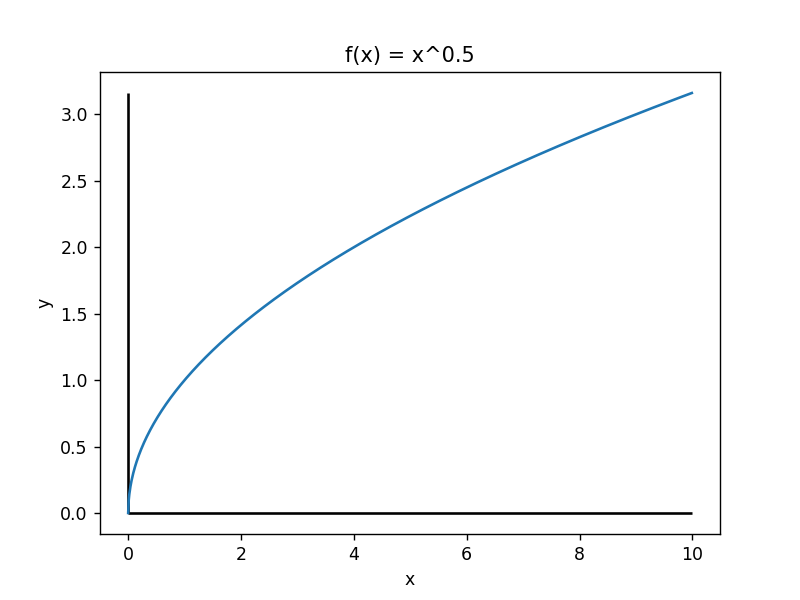

In [165]:
plot_expr(expr, np.arange(0, 10, 0.01))

<IPython.core.display.Javascript object>


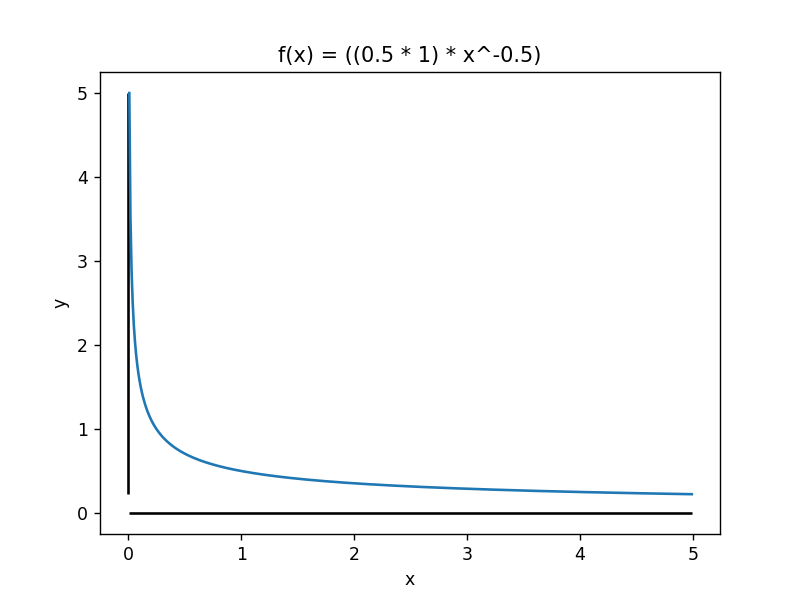

In [158]:
plot_expr(der, np.arange(0.01, 5, 0.01))

#### z = x^2 + y^2

In [137]:
expr = Add(Quad(Var("x"), Const(2)), Quad(Var("y"), Const(2)))
j = jacobian(expr, ["x", "y"])

In [138]:
print(expr)

(x^2 + y^2)


In [140]:
print(j[0], "," , j[1])

(((2 * 1) * x^1) + ((2 * 0) * y^1)) , (((2 * 0) * x^1) + ((2 * 1) * y^1))


In [144]:
print(list(map(lambda x: x.eval({"x": 1, "y": 2}), j)))

[2, 4]


### Taylor series

#### e^x

In [221]:
expr = Exp(Const(math.e), Var("x"))
taylor = taylor_expr(expr, a=0, order=7)

In [222]:
print(expr.eval({"x": 1}))
print(taylor.eval({"x": 1}))

2.718281828459045
2.7182539682539684


<IPython.core.display.Javascript object>


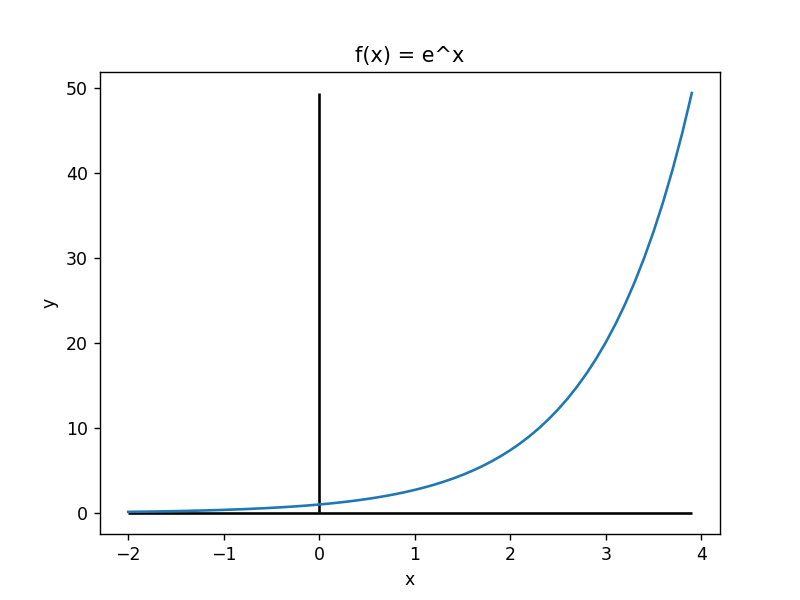

<IPython.core.display.Javascript object>


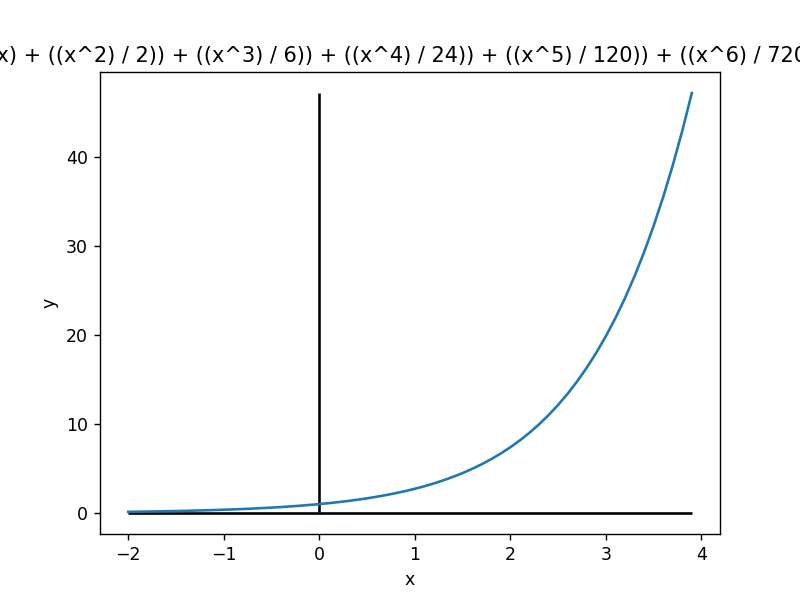

In [223]:
plot_expr(expr, np.arange(-2, 4, 0.1))
plot_expr(taylor, np.arange(-2, 4, 0.1))

#### sin(x)

In [301]:
expr = Sin(Var("x"))
taylor = taylor_expr(expr, a=0, order=100)

In [302]:
taylor.eval({"x": math.pi / 180 * 90})

1.0000000000000002

<IPython.core.display.Javascript object>


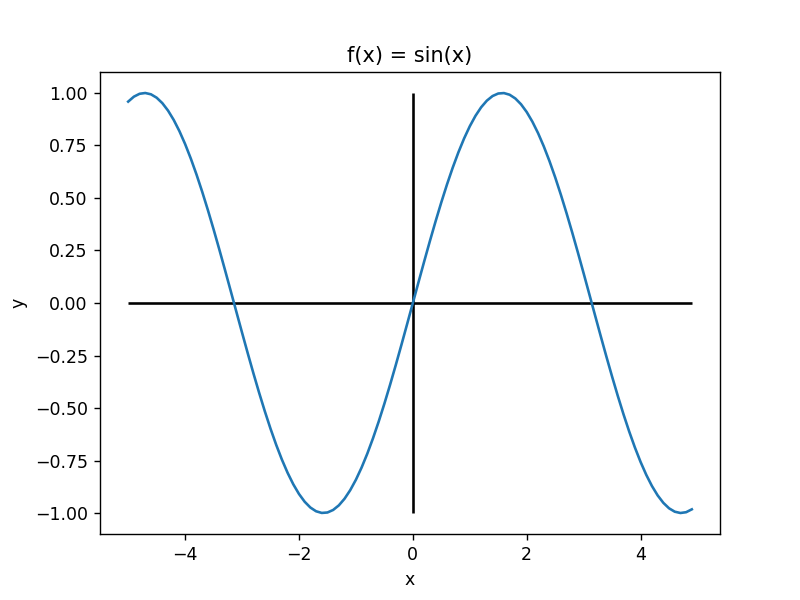

<IPython.core.display.Javascript object>


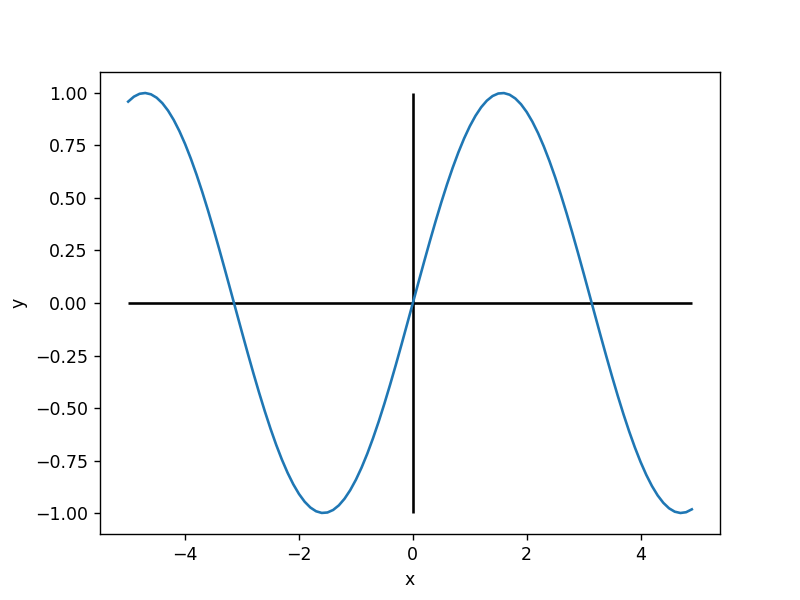

In [303]:
plot_expr(expr, np.arange(-5, 5, 0.1))
plot_expr(taylor, np.arange(-5, 5, 0.1))

#### ln(x)

In [322]:
expr = Log(Var("x"))
taylor = taylor_expr(expr, a=1, order=8)

<IPython.core.display.Javascript object>


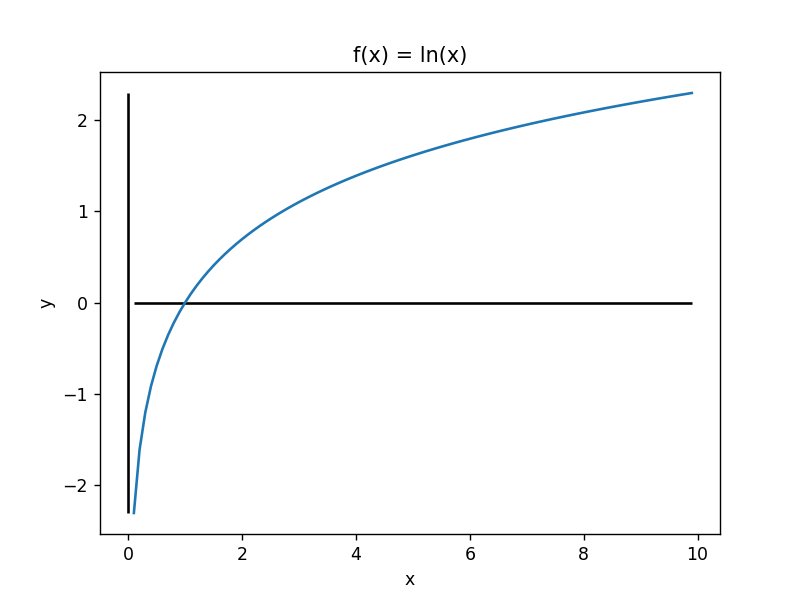

<IPython.core.display.Javascript object>


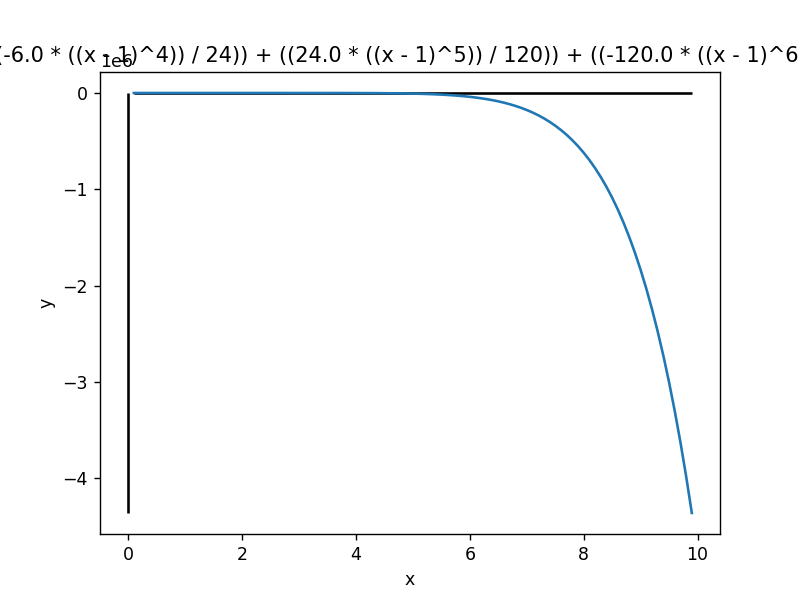

In [323]:
plot_expr(expr, np.arange(0.1, 10, 0.1))
plot_expr(taylor, np.arange(0.1, 10, 0.1))

### Function String Parsing

In [140]:
func = "(sin(x+1))"

In [156]:
def parse(func):
    # sin
    if re.match(r"^\(?sin\([\S]+\)\)?$", func):
        inside = re.findall(r"^\(?sin\((.+)\)\)?$", func)[0]
        return Sin(parse(inside))
    elif "+" in func:
        s = func.split("+")
        return Add(parse(s[0].strip()), parse(s[1].strip()))
    # const
    elif re.match(r"^\(?\d+\)?$", func):
        const = re.findall(r"(\d+)", func)[0]
        return Const(float(const))
    elif "x" in func:
        return Var(func)
    print(func)
    return

In [157]:
expr = parse(func)

In [158]:
print(expr)

sin((x + 1.0))


In [159]:
expr.eval({"x": math.pi / 6 - 1})

0.49999999999999994